In [1]:
!nvidia-smi

Fri Apr 22 10:22:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8     8W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/tengyangtianxia1/SAR_dataset.git
!mv ./SAR_dataset/conformer.py ./

Cloning into 'SAR_dataset'...
remote: Enumerating objects: 9489, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9489 (delta 2), reused 5 (delta 1), pack-reused 9482
Receiving objects: 100% (9489/9489), 650.37 MiB | 26.07 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (9465/9465), done.


In [ ]:
!ls

conformer.py  __pycache__  sample_data	SAR_dataset


In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 5.3 MB/s 


In [9]:
import torch
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import timm
from torch import nn
from tqdm import tqdm
from torchvision.ops import sigmoid_focal_loss
from conformer import Conformer
from torch.utils.data import DataLoader
from torch.optim import AdamW
%matplotlib inline

In [3]:
def get_dataloader(train_batch_size, test_batch_size, num_workers, m_transform):
    train_dataset = ImageFolder('./SAR_dataset/train/',m_transform)
    test_dataset = ImageFolder('./SAR_dataset/test/',simple_transform)
    Gtest_dataset = ImageFolder('./SAR_dataset/Gtest/',simple_transform)
    Itest_dataset = ImageFolder('./SAR_dataset/Itest/',simple_transform)
    train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
    test_loader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)
    Gtest_loader = DataLoader(Gtest_dataset, batch_size = test_batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)
    Itest_loader = DataLoader(Itest_dataset, batch_size = test_batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)
    return train_loader, test_loader, Gtest_loader, Itest_loader


# simple_transform = transforms.Compose([transforms.Grayscale(1),#灰度
#                     transforms.ToTensor(),
#                     transforms.Normalize([0.1098],[0.1023])]
#                     )
# Itest_transform  = transforms.Compose([transforms.Grayscale(1),#灰度
#                     transforms.ToTensor(),
#                     transforms.Normalize([0.0992],[0.1313])]
#                     )
# train_dataset = ImageFolder('./SAR_dataset/train/',simple_transform)
# test_dataset = ImageFolder('./SAR_dataset/test/',simple_transform)
# Gtest_dataset = ImageFolder('./SAR_dataset/Gtest/',simple_transform)
# Itest_dataset = ImageFolder('./SAR_dataset/Itest/',simple_transform)

In [4]:
def Conformer_tiny_patch16(pretrained=False, **kwargs):
    model = Conformer(patch_size=16, channel_ratio=1, embed_dim=384, depth=12,
                      num_heads=3, mlp_ratio=4, qkv_bias=True, **kwargs)
    if pretrained:
        raise NotImplementedError
    return model

In [5]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
	optimizer: Optimizer,
	num_warmup_steps: int,
	num_training_steps: int,
	num_cycles: float = 0.5,
	last_epoch: int = -1,
):
	"""
	Create a schedule with a learning rate that decreases following the values of the cosine function between the
	initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
	initial lr set in the optimizer.

	Args:
		optimizer (:class:`~torch.optim.Optimizer`):
		The optimizer for which to schedule the learning rate.
		num_warmup_steps (:obj:`int`):
		The number of steps for the warmup phase.
		num_training_steps (:obj:`int`):
		The total number of training steps.
		num_cycles (:obj:`float`, `optional`, defaults to 0.5):
		The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
		following a half-cosine).
		last_epoch (:obj:`int`, `optional`, defaults to -1):
		The index of the last epoch when resuming training.

	Return:
		:obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
	"""
	def lr_lambda(current_step):
		# Warmup
		if current_step < num_warmup_steps:
			return float(current_step) / float(max(1, num_warmup_steps))
		# decadence
		progress = float(current_step - num_warmup_steps) / float(
			max(1, num_training_steps - num_warmup_steps)
		)
		return max(
			0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
		)

	return LambdaLR(optimizer, lr_lambda, last_epoch)

In [ ]:
lr = 1e-3
num_epoch = 15
train_batch_size= 32
test_batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, num_workers = 4, pin_memory = True, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, num_workers = 4, pin_memory = True, shuffle = False)
Gtest_loader = torch.utils.data.DataLoader(Gtest_dataset, batch_size = test_batch_size, num_workers = 4, pin_memory = True, shuffle = False)
Itest_loader = torch.utils.data.DataLoader(Itest_dataset, batch_size = test_batch_size, num_workers = 4, pin_memory = True, shuffle = False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
def compute_loss(o, target, num_classes):
    target = target.unsqueeze(1)
    target = torch.zeros(target.shape[0],num_classes).cuda().scatter_(1,target,1)
    loss = sigmoid_focal_loss(o, target, reduction='mean')
    return loss


In [7]:
def model_fn(batch, model, device):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    if isinstance(outputs, list):
        loss_list = [compute_loss(o, labels, 2) / len(outputs) for o in outputs]
        loss = sum(loss_list)
    else:
        loss = compute_loss(outputs, labels, 2)
    if isinstance(outputs, list):
        out = sum(outputs)
    else:
        out = outputs
    preds = out.argmax(1)
    accuracy = torch.mean((preds == labels).float())
    return loss, accuracy
    
    

In [8]:
def model_test(data_loader, model, device, desc):
    
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    pbar = tqdm(total=len(data_loader.dataset), ncols=0, desc=desc, unit = 'uttr')
    
    for i, batch in enumerate(data_loader):
        with torch.no_grad():
            loss, accuracy = model_fn(batch, model, device)
            running_loss += loss.item()
            running_accuracy += accuracy.item()
        
        pbar.update(data_loader.batch_size)
        pbar.set_postfix(loss=f'{running_loss/(i+1):.2f}',
                        accuracy=f'{running_accuracy / (i+1):.2f}',
                    )
    pbar.close()
    model.train()
    return running_accuracy / len(data_loader)
    

In [ ]:
simple_transform = transforms.Compose([transforms.Grayscale(1),#灰度
                    transforms.ToTensor(),
                    transforms.Normalize([0.1098],[0.1023])]
                    )
def parse_args():
    """arguments"""
    config = {
        "train_batch_size": 32,
        "test_batch_size":16,
        "num_workers": 8,
        "test_steps": 2000,
        "warmup_steps": 1000,
        "save_steps": 10000,
        "total_steps": 100000,
        "m_transform":simple_transform
    }

    return config


def main(train_batch_size,
         test_batch_size,
         num_workers,
         test_steps,
         warmup_steps,
         total_steps,
         save_steps,
         m_transform
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")
    train_loader, test_loader, Gtest_loader, Itest_loader = get_dataloader(train_batch_size,test_batch_size,num_workers,m_transform)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)
    
    model = Conformer_tiny_patch16(in_chans=1, num_classes=2).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-3)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!",flush = True)

    best_accuracy = -1.0
    best_state_dict = None
    
    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")
    
    for step in range(total_steps):
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)
        loss, accuracy = model_fn(batch, model, device)
        batch_loss = loss.item()
        batch_accuracy = accuracy.item()
        
        # Updata model
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

# Log
        pbar.update()
        pbar.set_postfix(
			loss=f"{batch_loss:.2f}",
			accuracy=f"{batch_accuracy:.2f}",
			step=step + 1,
		)


    

In [ ]:
model = Conformer_tiny_patch16(in_chans=1, num_classes=2)
model = model.to(try_gpu())
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epoch)
train_losses = []
train_accs = []
test_losses =[]
test_accs = []
Gtest_losses = []
Gtest_accs = []
Itest_losses = []
Itest_accs = []
for epoch in range(num_epoch):
    model.train()
    print('Starting epoch ',str(int(epoch+1)))
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    Gtest_loss = []
    Gtest_acc = []
    Itest_loss = []
    Itest_acc = []
    for inputs,labels in tqdm(train_loader):
        inputs = inputs.to(try_gpu())
        labels = labels.to(try_gpu())
        outputs = model(inputs)
        if isinstance(outputs, list):
            loss_list = [compute_loss(o, labels, 2) / len(outputs) for o in outputs]
            loss = sum(loss_list)
        else:
            loss = compute_loss(outputs, labels, 2)
#         loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if isinstance(outputs,list):
            out = sum(outputs)
            train_acc.append((out.argmax(dim=-1) == labels).float().mean().cpu())
        else:
            train_acc.append((outputs.argmax(dim=-1) == labels).float().mean().cpu())
    print('第',str(int(epoch+1)),'个epoch的学习率为：',str(optimizer.param_groups[0]['lr']))
    scheduler.step()
    train_losses.append(np.sum(train_loss) / len(train_loss))
    train_accs.append(np.sum(train_acc)/len(train_acc))
    print('[ Train ',str(epoch+1),'/',str(num_epoch),' ] loss = ',str(train_losses[epoch]))
    print('[ Train ',str(epoch+1),'/',str(num_epoch),' ] accuracy = ',str(train_accs[epoch]))
    model.eval()
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(try_gpu())
        labels = labels.to(try_gpu())
        logits = model(inputs)
        if isinstance(logits, list):
            loss_list = [compute_loss(o, labels, 2) / len(logits) for o in logits]
            loss = sum(loss_list)
        else:
            loss = compute_loss(logits, labels, 2)
        # loss = criterion(logits,labels)
        test_loss.append(loss.item())
        if isinstance(logits,list):
            out = sum(logits)
            test_acc.append((out.argmax(dim=-1) == labels).float().mean().cpu())
        else:
            test_acc.append((logits.argmax(dim=-1) == labels).float().mean().cpu())
    test_losses.append(np.sum(test_loss) / len(test_loss))
    test_accs.append(np.sum(test_acc)/len(test_acc))
    for inputs, labels in tqdm(Gtest_loader):
        inputs = inputs.to(try_gpu())
        labels = labels.to(try_gpu())
        logits = model(inputs)
        if isinstance(logits, list):
            loss_list = [compute_loss(o, labels, 2) / len(logits) for o in logits]
            loss = sum(loss_list)
        else:
            loss = compute_loss(logits, labels, 2)
        # loss = criterion(logits,labels)
        Gtest_loss.append(loss.item())
        if isinstance(logits,list):
            out = sum(logits)
            Gtest_acc.append((out.argmax(dim=-1) == labels).float().mean().cpu())
        else:
            Gtest_acc.append((logits.argmax(dim=-1) == labels).float().mean().cpu())
        # Gtest_acc.append((logits.argmax(dim=-1) == labels).float().mean().cpu())
    Gtest_losses.append(np.sum(Gtest_loss) / len(Gtest_loss))
    Gtest_accs.append(np.sum(Gtest_acc)/len(Gtest_acc))
    for inputs, labels in tqdm(Itest_loader):
        inputs = inputs.to(try_gpu())
        labels = labels.to(try_gpu())
        logits = model(inputs)
        if isinstance(logits, list):
            loss_list = [compute_loss(o, labels, 2) / len(logits) for o in logits]
            loss = sum(loss_list)
        else:
            loss = compute_loss(logits, labels, 2)
        # loss = criterion(logits,labels)
        Itest_loss.append(loss.item())
        if isinstance(logits,list):
            out = sum(logits)
            Itest_acc.append((out.argmax(dim=-1) == labels).float().mean().cpu())
        else:
            Itest_acc.append((logits.argmax(dim=-1) == labels).float().mean().cpu())
    Itest_losses.append(np.sum(Itest_loss) / len(Itest_loss))
    Itest_accs.append(np.sum(Itest_acc)/len(Itest_acc))
    print('[ Test ',str(epoch+1),'/',str(num_epoch),' ] loss = ',str(test_losses[epoch]))
    print('[ Test ',str(epoch+1),'/',str(num_epoch),' ] accuracy = ',str(test_accs[epoch]))
    print('[ GTest ',str(epoch+1),'/',str(num_epoch),' ] loss = ',str(Gtest_losses[epoch]))
    print('[ GTest ',str(epoch+1),'/',str(num_epoch),' ] accuracy = ',str(Gtest_accs[epoch]))
    print('[ ITest ',str(epoch+1),'/',str(num_epoch),' ] loss = ',str(Itest_losses[epoch]))
    print('[ ITest ',str(epoch+1),'/',str(num_epoch),' ] accuracy = ',str(Itest_accs[epoch]))
    #保存此次epoch的模型
    torch.save(model.state_dict(),'./epoch'+str(epoch+1)+'acc='+str(test_accs[epoch])+'.pth')

Starting epoch  1


  0%|          | 0/191 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 191/191 [03:45<00:00,  1.18s/it]


第 1 个epoch的学习率为： 0.001
[ Train  1 / 15  ] loss =  0.06124877982348672
[ Train  1 / 15  ] accuracy =  0.7536696189361093


100%|██████████| 51/51 [00:11<00:00,  4.48it/s]


[ Test  1 / 15  ] loss =  0.05812224179506302
[ Test  1 / 15  ] accuracy =  0.7516666666666667
[ GTest  1 / 15  ] loss =  0.060164677371319975
[ GTest  1 / 15  ] accuracy =  0.7368421052631579
[ ITest  1 / 15  ] loss =  0.040412716530993875
[ ITest  1 / 15  ] accuracy =  0.9068627450980392
Starting epoch  2


100%|██████████| 191/191 [03:44<00:00,  1.17s/it]


第 2 个epoch的学习率为： 0.0009890738003669028
[ Train  2 / 15  ] loss =  0.053348963875421054
[ Train  2 / 15  ] accuracy =  0.7855740691978894


100%|██████████| 51/51 [00:11<00:00,  4.45it/s]


[ Test  2 / 15  ] loss =  0.05776485552390417
[ Test  2 / 15  ] accuracy =  0.77
[ GTest  2 / 15  ] loss =  0.05931711216506205
[ GTest  2 / 15  ] accuracy =  0.7368421052631579
[ ITest  2 / 15  ] loss =  0.04238077443020016
[ ITest  2 / 15  ] accuracy =  0.9068627450980392
Starting epoch  3


100%|██████████| 191/191 [03:43<00:00,  1.17s/it]


第 3 个epoch的学习率为： 0.0009567727288213003
[ Train  3 / 15  ] loss =  0.05106743737197047
[ Train  3 / 15  ] accuracy =  0.8147905759162304


100%|██████████| 51/51 [00:11<00:00,  4.45it/s]


[ Test  3 / 15  ] loss =  0.05126359201967716
[ Test  3 / 15  ] accuracy =  0.8408333333333333
[ GTest  3 / 15  ] loss =  0.05869020874563016
[ GTest  3 / 15  ] accuracy =  0.7510964744969418
[ ITest  3 / 15  ] loss =  0.05311184643092109
[ ITest  3 / 15  ] accuracy =  0.8458333482929304
Starting epoch  4


100%|██████████| 191/191 [03:43<00:00,  1.17s/it]


第 4 个epoch的学习率为： 0.0009045084971874737
[ Train  4 / 15  ] loss =  0.04892179549364519
[ Train  4 / 15  ] accuracy =  0.8328346931497465


100%|██████████| 51/51 [00:11<00:00,  4.48it/s]


[ Test  4 / 15  ] loss =  0.04916189762453238
[ Test  4 / 15  ] accuracy =  0.8525
[ GTest  4 / 15  ] loss =  0.055724825121854484
[ GTest  4 / 15  ] accuracy =  0.7478070008127313
[ ITest  4 / 15  ] loss =  0.0453220556544907
[ ITest  4 / 15  ] accuracy =  0.8737745098039216
Starting epoch  5


100%|██████████| 191/191 [03:43<00:00,  1.17s/it]


第 5 个epoch的学习率为： 0.0008345653031794292
[ Train  5 / 15  ] loss =  0.04667139054319933
[ Train  5 / 15  ] accuracy =  0.8574701279245746


100%|██████████| 51/51 [00:11<00:00,  4.50it/s]


[ Test  5 / 15  ] loss =  0.05806158563743035
[ Test  5 / 15  ] accuracy =  0.7958333333333333
[ GTest  5 / 15  ] loss =  0.058944103259005044
[ GTest  5 / 15  ] accuracy =  0.777412263970626
[ ITest  5 / 15  ] loss =  0.040688884499318456
[ ITest  5 / 15  ] accuracy =  0.8958333333333334
Starting epoch  6


100%|██████████| 191/191 [03:43<00:00,  1.17s/it]


第 6 个epoch的学习率为： 0.00075
[ Train  6 / 15  ] loss =  0.044383337428666535
[ Train  6 / 15  ] accuracy =  0.8686424375204516


100%|██████████| 51/51 [00:11<00:00,  4.47it/s]


[ Test  6 / 15  ] loss =  0.047758072366317114
[ Test  6 / 15  ] accuracy =  0.8741666666666666
[ GTest  6 / 15  ] loss =  0.05502359451431977
[ GTest  6 / 15  ] accuracy =  0.7719298412925318
[ ITest  6 / 15  ] loss =  0.052948352533812616
[ ITest  6 / 15  ] accuracy =  0.8387255201152727
Starting epoch  7


100%|██████████| 191/191 [03:42<00:00,  1.17s/it]


第 7 个epoch的学习率为： 0.0006545084971874737
[ Train  7 / 15  ] loss =  0.042138134251246274
[ Train  7 / 15  ] accuracy =  0.8920858493026015


100%|██████████| 51/51 [00:11<00:00,  4.47it/s]


[ Test  7 / 15  ] loss =  0.0643195205554366
[ Test  7 / 15  ] accuracy =  0.7691666666666667
[ GTest  7 / 15  ] loss =  0.05424210380174612
[ GTest  7 / 15  ] accuracy =  0.770833316602205
[ ITest  7 / 15  ] loss =  0.040236600802517404
[ ITest  7 / 15  ] accuracy =  0.9068627450980392
Starting epoch  8


100%|██████████| 191/191 [03:43<00:00,  1.17s/it]


第 8 个epoch的学习率为： 0.0005522642316338268
[ Train  8 / 15  ] loss =  0.039972482453934186
[ Train  8 / 15  ] accuracy =  0.9097325989089087


100%|██████████| 51/51 [00:11<00:00,  4.46it/s]


[ Test  8 / 15  ] loss =  0.0432973192880551
[ Test  8 / 15  ] accuracy =  0.8716666666666667
[ GTest  8 / 15  ] loss =  0.04969620381138826
[ GTest  8 / 15  ] accuracy =  0.777412263970626
[ ITest  8 / 15  ] loss =  0.05439888039494262
[ ITest  8 / 15  ] accuracy =  0.8384804071164599
Starting epoch  9


100%|██████████| 191/191 [03:43<00:00,  1.17s/it]


第 9 个epoch的学习率为： 0.0004477357683661734
[ Train  9 / 15  ] loss =  0.03756769573930358
[ Train  9 / 15  ] accuracy =  0.9227748691099477


100%|██████████| 51/51 [00:11<00:00,  4.46it/s]


[ Test  9 / 15  ] loss =  0.04378839612007141
[ Test  9 / 15  ] accuracy =  0.8875
[ GTest  9 / 15  ] loss =  0.05130893295924915
[ GTest  9 / 15  ] accuracy =  0.8146929991872687
[ ITest  9 / 15  ] loss =  0.057497327562932875
[ ITest  9 / 15  ] accuracy =  0.7987744948443245
Starting epoch  10


100%|██████████| 191/191 [03:43<00:00,  1.17s/it]


第 10 个epoch的学习率为： 0.0003454915028125264
[ Train  10 / 15  ] loss =  0.035878656870875686
[ Train  10 / 15  ] accuracy =  0.9370324898764725


100%|██████████| 51/51 [00:11<00:00,  4.45it/s]


[ Test  10 / 15  ] loss =  0.042411906520525615
[ Test  10 / 15  ] accuracy =  0.9125
[ GTest  10 / 15  ] loss =  0.045324928078212236
[ GTest  10 / 15  ] accuracy =  0.8322368421052632
[ ITest  10 / 15  ] loss =  0.07805392116892572
[ ITest  10 / 15  ] accuracy =  0.760784298765893
Starting epoch  11


100%|██████████| 191/191 [03:44<00:00,  1.17s/it]


第 11 个epoch的学习率为： 0.0002500000000000001
[ Train  11 / 15  ] loss =  0.03200671228906871
[ Train  11 / 15  ] accuracy =  0.9538379289716951


100%|██████████| 51/51 [00:11<00:00,  4.51it/s]


[ Test  11 / 15  ] loss =  0.036568598089118796
[ Test  11 / 15  ] accuracy =  0.9175
[ GTest  11 / 15  ] loss =  0.03923975377294578
[ GTest  11 / 15  ] accuracy =  0.867324527941252
[ ITest  11 / 15  ] loss =  0.0664890865777053
[ ITest  11 / 15  ] accuracy =  0.8178921867819393
Starting epoch  12


100%|██████████| 191/191 [03:42<00:00,  1.16s/it]


第 12 个epoch的学习率为： 0.00016543469682057103
[ Train  12 / 15  ] loss =  0.029172059294831066
[ Train  12 / 15  ] accuracy =  0.9690538975580825


100%|██████████| 51/51 [00:11<00:00,  4.51it/s]


[ Test  12 / 15  ] loss =  0.03441351833442847
[ Test  12 / 15  ] accuracy =  0.925
[ GTest  12 / 15  ] loss =  0.04239578329418835
[ GTest  12 / 15  ] accuracy =  0.8662281036376953
[ ITest  12 / 15  ] loss =  0.06036374860388391
[ ITest  12 / 15  ] accuracy =  0.8458333482929304
Starting epoch  13


100%|██████████| 191/191 [03:42<00:00,  1.16s/it]


第 13 个epoch的学习率为： 9.549150281252631e-05
[ Train  13 / 15  ] loss =  0.026274093178086256
[ Train  13 / 15  ] accuracy =  0.981675392670157


100%|██████████| 51/51 [00:11<00:00,  4.48it/s]


[ Test  13 / 15  ] loss =  0.03493369959294796
[ Test  13 / 15  ] accuracy =  0.9325
[ GTest  13 / 15  ] loss =  0.037522392592539915
[ GTest  13 / 15  ] accuracy =  0.8859649457429585
[ ITest  13 / 15  ] loss =  0.08538287153065789
[ ITest  13 / 15  ] accuracy =  0.8110293968051088
Starting epoch  14


100%|██████████| 191/191 [03:41<00:00,  1.16s/it]


第 14 个epoch的学习率为： 4.322727117869951e-05
[ Train  14 / 15  ] loss =  0.024436207044460076
[ Train  14 / 15  ] accuracy =  0.9824701279245746


100%|██████████| 51/51 [00:11<00:00,  4.52it/s]


[ Test  14 / 15  ] loss =  0.03415466886013746
[ Test  14 / 15  ] accuracy =  0.9283333333333333
[ GTest  14 / 15  ] loss =  0.03549666658632065
[ GTest  14 / 15  ] accuracy =  0.8991228404798006
[ ITest  14 / 15  ] loss =  0.0944294910147494
[ ITest  14 / 15  ] accuracy =  0.7887254602768842
Starting epoch  15


100%|██████████| 191/191 [03:42<00:00,  1.17s/it]


第 15 个epoch的学习率为： 1.0926199633097156e-05
[ Train  15 / 15  ] loss =  0.023481396958231926
[ Train  15 / 15  ] accuracy =  0.9834283958554892


100%|██████████| 51/51 [00:11<00:00,  4.50it/s]


[ Test  15 / 15  ] loss =  0.03257125904162725
[ Test  15 / 15  ] accuracy =  0.9366666666666666
[ GTest  15 / 15  ] loss =  0.03544548996969273
[ GTest  15 / 15  ] accuracy =  0.8925438931113795
[ ITest  15 / 15  ] loss =  0.08429577784137983
[ ITest  15 / 15  ] accuracy =  0.8049019458247166


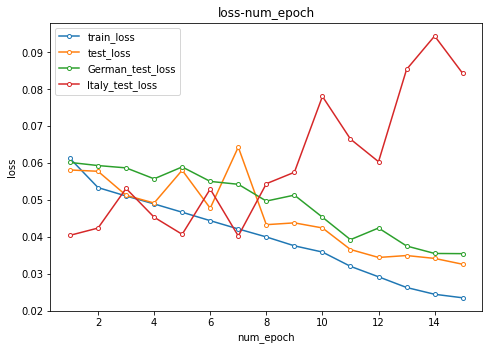

In [ ]:
#绘制损失函数图
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = np.arange(1,num_epoch+1)
ax.plot(x,train_losses, marker='o' ,markersize =4, mfc='white' ,label='train_loss')
ax.plot(x,test_losses, marker='o' ,markersize =4, mfc='white' ,label='test_loss')
ax.plot(x,Gtest_losses, marker='o' ,markersize =4, mfc='white' ,label='German_test_loss')
ax.plot(x,Itest_losses, marker='o' ,markersize =4, mfc='white' ,label='Italy_test_loss')
ax.set_title('loss-num_epoch')
ax.set_xlabel('num_epoch')
ax.set_ylabel('loss')
ax.legend()

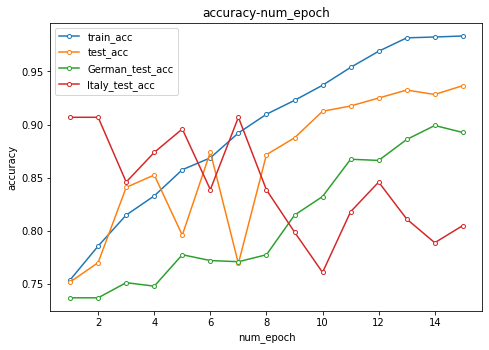

In [ ]:
#绘制准确率图
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = np.arange(1,num_epoch+1)
ax.plot(x,train_accs, marker='o' ,markersize =4, mfc='white' ,label='train_acc')
ax.plot(x,test_accs, marker='o' ,markersize =4, mfc='white' ,label='test_acc')
ax.plot(x,Gtest_accs, marker='o' ,markersize =4, mfc='white' ,label='German_test_acc')
ax.plot(x,Itest_accs, marker='o' ,markersize =4, mfc='white' ,label='Italy_test_acc')
ax.set_title('accuracy-num_epoch')
ax.set_xlabel('num_epoch')
ax.set_ylabel('accuracy')
ax.legend()